In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2



In [2]:
DATADIR= r"C:\Users\tanvi\dataset\training_set"
CATEGORIES = ["dogs","cats"]


In [3]:
training_data=[]

def prepare_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(50,50))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
 
prepare_train_data()        

In [4]:
print(len(training_data))

8000


In [5]:
import random 
random.shuffle(training_data)

In [6]:
for sample in training_data[:10]:
    print(sample[1])

1
1
0
0
0
0
1
1
0
1


In [7]:
X= []
Y= []


In [8]:
for feature, label in training_data:
    X.append(feature)
    Y.append(label)
    
X = np.array(X).reshape(-1, 50, 50, 1)    

In [9]:
train_x_flatten = X.reshape(X.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.


print ("train_x's shape: " + str(train_x.shape))




train_x's shape: (2500, 8000)


In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math

In [11]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [12]:
import numpy as np

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ



In [13]:
#for 2 layer model

def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)

    W1 = np.random.randn(n_h,n_x) *0.01
    b1= np.zeros(shape=(n_h,1))
    W2= np.random.randn(n_y,n_h)* 0.01
    b2 = np.zeros(shape=(n_y,1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters 

In [14]:
def linear_forward(A,W,b):

    Z = W @ A + b
    cache = (A,W,b)

    return Z,cache

In [15]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation=="sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation== "relu":
        Z,linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache    

In [16]:
#cost calculation
def compute_cost(AL, Y):

    m = Y.shape[1]

    cost = -1/m * np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))

    cost = np.squeeze(cost)
    return cost

In [17]:
#backpropagation
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m* dZ @ A_prev.T
    db = 1/m* np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T @ dZ

    return dA_prev, dW, db

In [18]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation =="relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db    

In [19]:
def update_parameters(parameters, grads, learning_rate):

    L= len(parameters) //2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] -learning_rate * grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] -learning_rate * grads["db"+str(l+1)]
    return parameters   

In [20]:
n_x = 2500     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [21]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    print(len(parameters))
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1,activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2,activation='sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2,Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [22]:
Y = np.array(Y).reshape(1,8000)
print(train_x.shape)
print(Y.shape)

(2500, 8000)
(1, 8000)


4
Cost after iteration 0: 0.6931418428499108
Cost after iteration 100: 0.6931149026458432
Cost after iteration 200: 0.6930851378745699
Cost after iteration 300: 0.6930497731480438
Cost after iteration 400: 0.693004918195444
Cost after iteration 500: 0.6929457299954825
Cost after iteration 600: 0.6928666447177583
Cost after iteration 700: 0.6927622128818463
Cost after iteration 800: 0.6926202328166557
Cost after iteration 900: 0.6924326686274115
Cost after iteration 1000: 0.692185762106272
Cost after iteration 1100: 0.6918625566915164
Cost after iteration 1200: 0.6914464597472124
Cost after iteration 1300: 0.6909207723013965
Cost after iteration 1400: 0.6902692403531284
Cost after iteration 1500: 0.6894877261551756
Cost after iteration 1600: 0.6885771601300861
Cost after iteration 1700: 0.6875522363337822
Cost after iteration 1800: 0.6864377676469962
Cost after iteration 1900: 0.6852578656269679
Cost after iteration 2000: 0.6840383338140877
Cost after iteration 2100: 0.6828132969058197


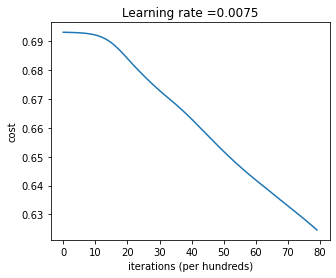

In [23]:
parameters = two_layer_model(train_x, Y, layers_dims = (n_x, n_h, n_y), num_iterations = 8000, print_cost=True)

In [24]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [25]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [26]:
predictions_train = predict(train_x, Y, parameters)

Accuracy: 0.6566250000000002
